In [1]:
from operator import itemgetter
import os
import re
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from collections import namedtuple
import csv
from itertools import repeat
import numpy as np
import math
import scipy.interpolate as inter
from statistics import mean

In [3]:
def read_verification_log(file_name):
    '''
    Read generated verification data from a csv file.

    Return: tuple of recorded errors and accuracies
    '''
    Errors = []
    Accs = []
    VerificationRecord = namedtuple('VerificationRecord', 'opt_error, accuracy')
    
    with open(file_name) as csvfile:
        readCSV = map(VerificationRecord._make, csv.reader(csvfile, delimiter=','))
        for row in readCSV:
            Errors.append(float(row.opt_error))
            Accs.append(float(row.accuracy))
    return (Errors, Accs)

    
# Smoothing as in TB: https://github.com/tensorflow/tensorflow/blob/905662a1c047f314ad295e27d2e2a00b4aa51e90/tensorflow/tensorboard/components/vz_line_chart/vz-line-chart.ts#L432
# Assume that we only have finite numbers.
def smooth_data(data, smoothing_weight=0.6):
    factor = ((1000** smoothing_weight) - 1) / 999
    kernel_radius = math.floor(len(data) * factor / 2)
    
    Y_smoothed = []
    
    for i, d in enumerate(data):
        actual_kernel_radius = min(kernel_radius, i, len(data) - i - 1)
        start = i - actual_kernel_radius
        end = i + actual_kernel_radius + 1
        
        Y_smoothed.append(mean(data[start:end]))
    
    return Y_smoothed


def plot_progress(X, Y, title='', ymax=1, ymin=0, ylabel=''):
    plt.ylim(ymin, ymax)
    plt.plot(X, Y)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Communication round')
    #plt.legend(['test'], loc='upper right')
    plt.show()

    
def interpolate_spline(X,Y, spacing, smoothing=0.0):
    s1 = inter.UnivariateSpline(X, Y, s=smoothing)
    xNew = np.linspace(min(X),max(X),spacing)
    return xNew, s1(xNew)


def monotone_progress(Accs):
    maximum = 0
    monotoneValues = []
    for acc in Accs:
        maximum = maximum if acc < maximum else acc
        monotoneValues.append(maximum)
    return monotoneValues
        

In [4]:
def simple_plot_progress(Y, title='', ymax=1, ymin=0, ylabel=''):
    plt.ylim(ymin, ymax)
    plt.plot(Y)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Communication round')
    plt.show()
    
def plot_overlap(*yls, ymin=0.0, ymax=1.0, file_name=None, title=None):

    fig = plt.figure(figsize=(5,4), dpi=300)
    #min_len = min([len(y) for y in ys])
    sorted_yls = list(zip(*yls))
    sorted_yls.sort(key=lambda ysl: max(ysl[0]), reverse=True)
    for y,l in sorted_yls:
        y_acc = monotone_progress(y)
        plt.plot(y_acc, alpha=0.7, label=l)
    
    if ymax == None:
        ymax = max([max(y) for y in yls[0]])
    
    plt.ylim(ymin, ymax)

    plt.ylabel("Accuracy")
    plt.xlabel("Communication rounds")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    if title:
        plt.title(title)
    
    if file_name:
        plt.savefig(file_name, format='pdf', bbox_inches="tight")
    
    plt.show(fig)

In [5]:
def extract_lr_decay(string):
    lr_match = re.search(r'(?<=_LR)\d+.\d+', string)
    lr = lr_match.group(0)
    lr = float(lr)
    decay_match = re.search(r'(?<=_Decay)\d+.\d+e(-)*\d+', string)
    decay = decay_match.group(0)
    decay = float(decay)
    return (lr,decay)

def plot_score_logs(score_logs, title=None, file_name=None):
    accs = [read_verification_log(file)[1] for file in score_logs]
    cs_es = ['$\eta={:.2f}$, $\lambda={:.1e}$'.format(extract_lr_decay(file)[0], extract_lr_decay(file)[1]) for file in score_logs]
    accs_labels = (accs, cs_es)

    plot_overlap(*accs_labels, ymin=0.92, ymax=0.97, file_name=file_name, title=title)

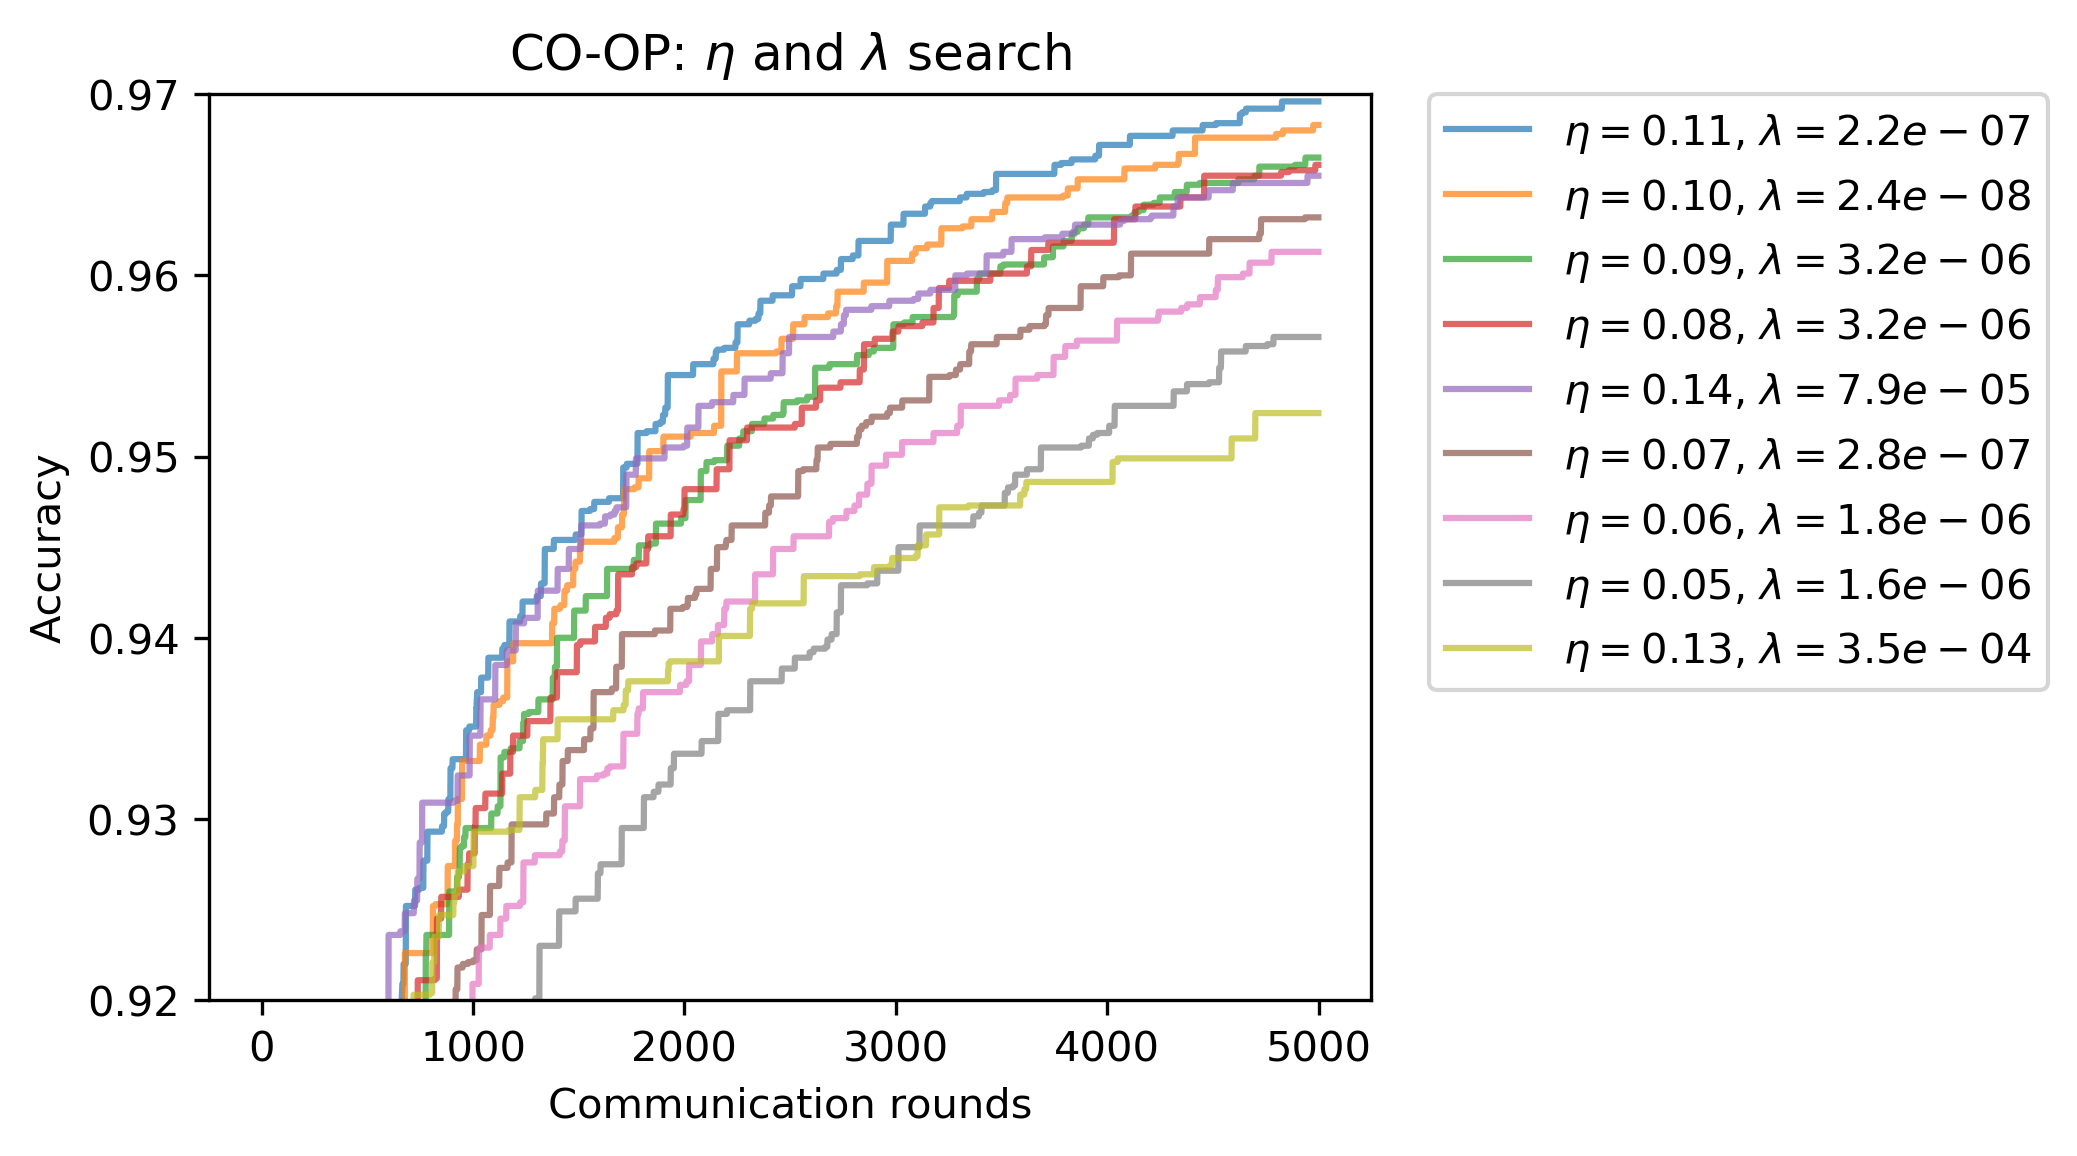

In [6]:
score_logs = glob.glob("../benchmark_results/coop/lr_decay/*.csv")

sorted_logs = sorted(score_logs, key=extract_lr_decay)

pdf_path = "../benchmark_results/coop/plot_coop_lr_decay.pdf"
title = 'CO-OP: $\eta$ and $\lambda$ search'
plot_score_logs(sorted_logs, title, pdf_path)

In [7]:
def extract_bl_bu(string):
    bl_match = re.search(r'(?<=_Bl)\d+', string)
    bl = bl_match.group(0)
    bl = int(bl)
    bu_match = re.search(r'(?<=_Bu)\d+', string)
    bu = bu_match.group(0)
    bu = int(bu)
    return (bl,bu)

def plot_score_logs_age(score_logs, title=None, file_name=None):
    accs = [read_verification_log(file)[1] for file in score_logs]
    cs_es = ['$b_l={}$, $b_u={}$'.format(*extract_bl_bu(file)) for file in score_logs]
    accs_labels = (accs, cs_es)

    plot_overlap(*accs_labels, ymin=0.6, ymax=0.97, file_name=file_name, title=title)

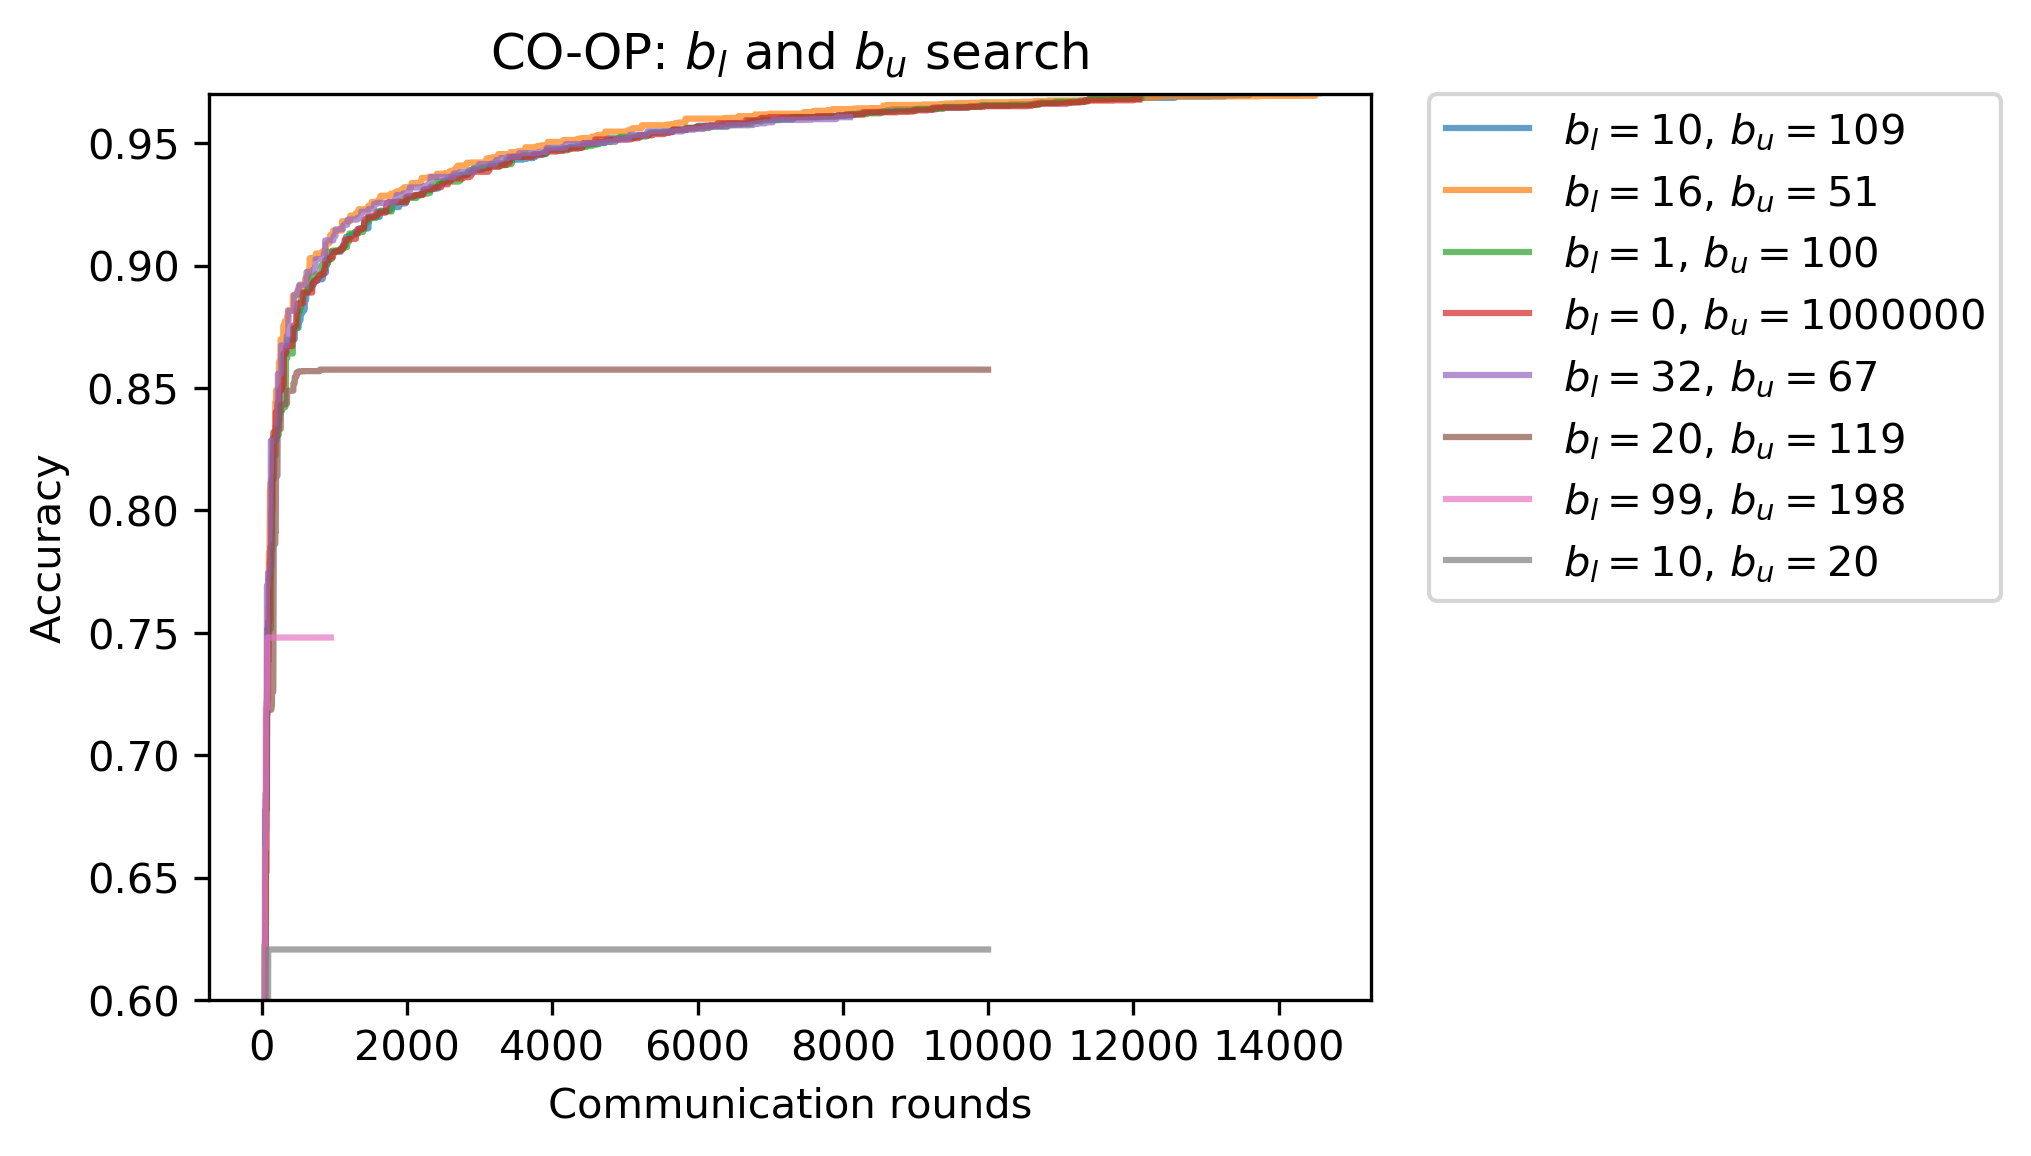

In [8]:
score_logs = glob.glob("../benchmark_results/coop/*.csv")

sorted_logs = sorted(score_logs, key=extract_bl_bu)

pdf_path = "../benchmark_results/coop/plot_coop.pdf"
title = 'CO-OP: $b_l$ and $b_u$ search'
plot_score_logs_age(sorted_logs, title)

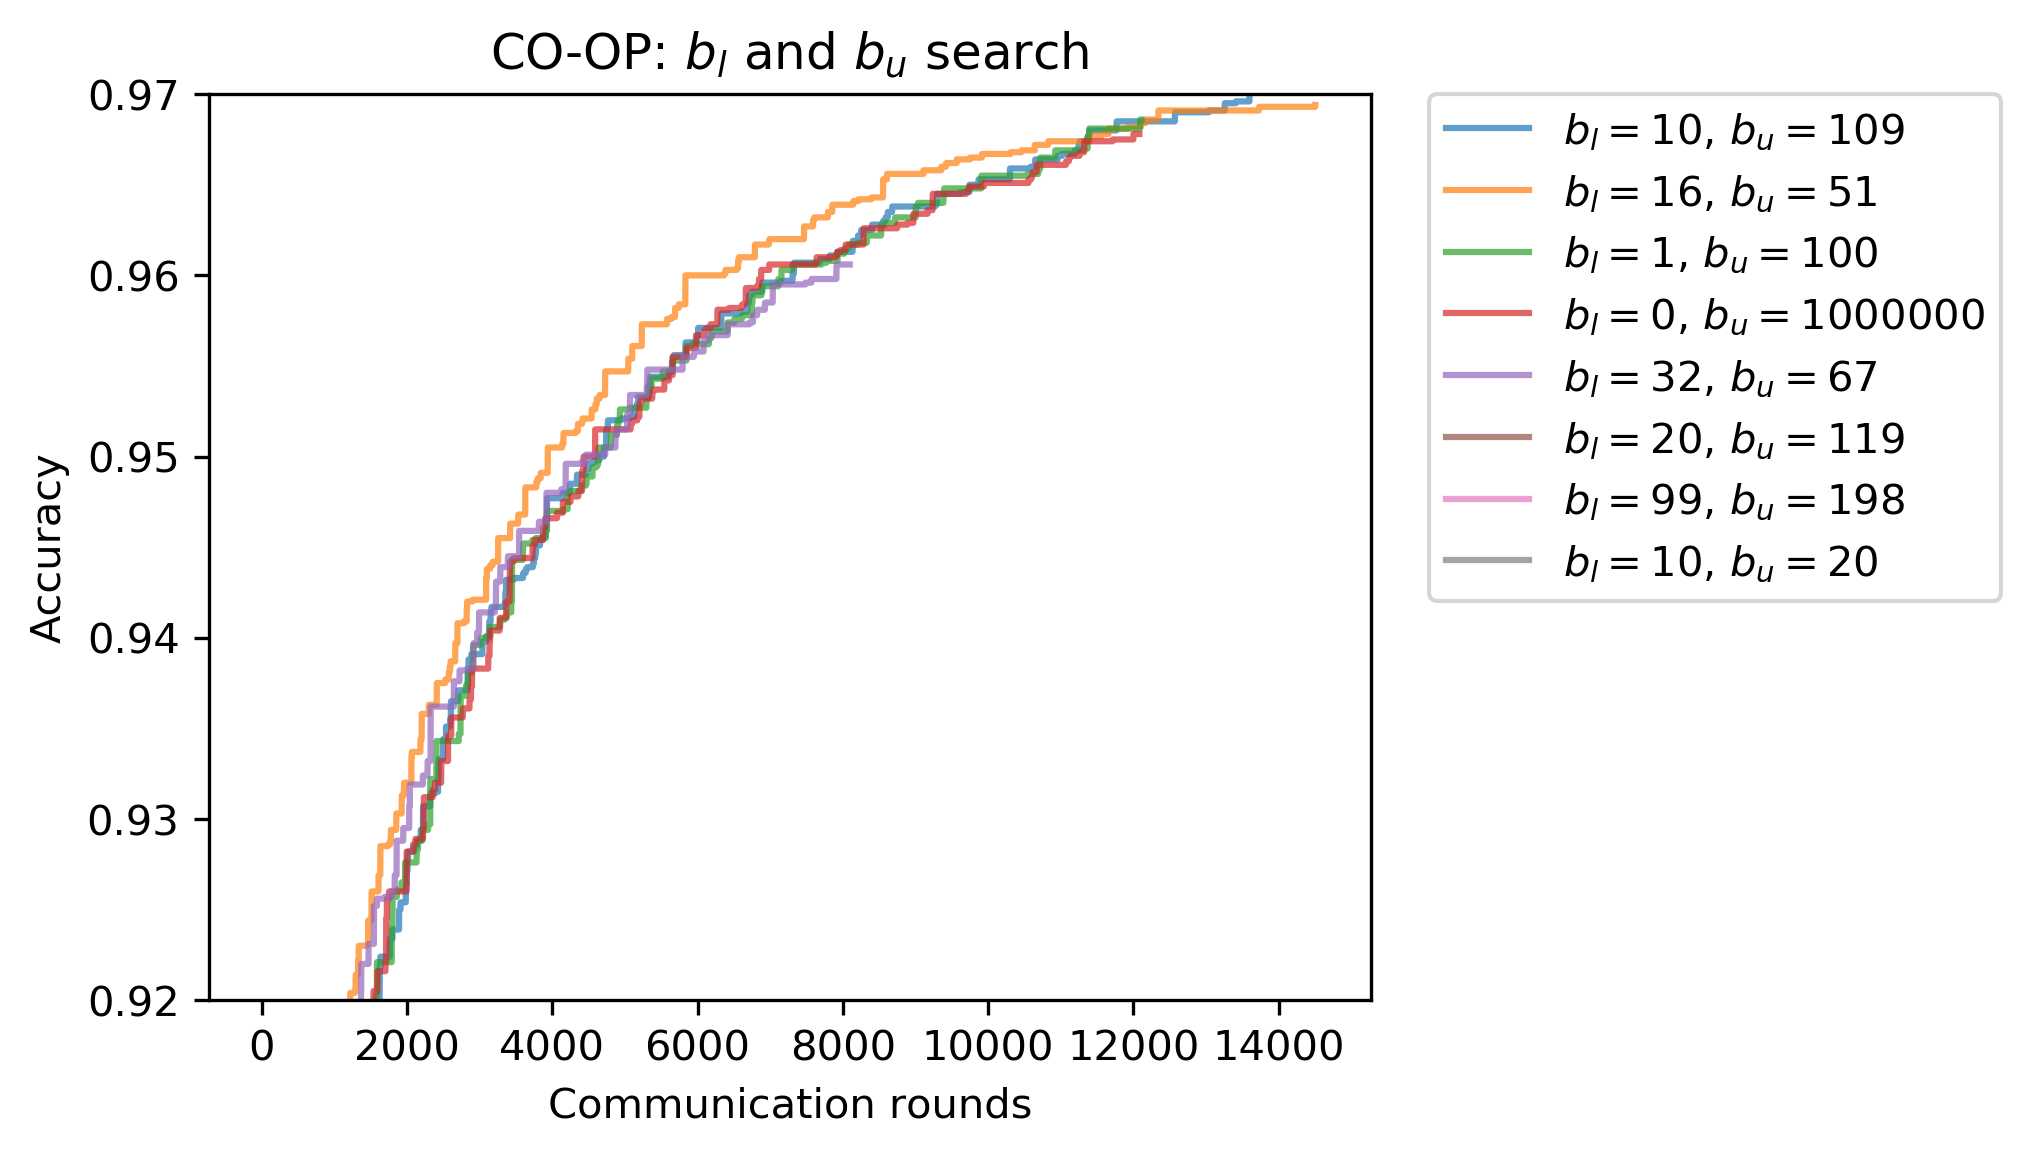

In [9]:
def plot_score_logs_age(score_logs, title=None, file_name=None):
    accs = [read_verification_log(file)[1] for file in score_logs]
    cs_es = ['$b_l={}$, $b_u={}$'.format(*extract_bl_bu(file)) for file in score_logs]
    accs_labels = (accs, cs_es)

    plot_overlap(*accs_labels, ymin=0.92, ymax=0.97, file_name=file_name, title=title)
    
score_logs = glob.glob("../benchmark_results/coop/*.csv")

sorted_logs = sorted(score_logs, key=extract_bl_bu)

pdf_path = "../benchmark_results/coop/plot_coop.pdf"
title = 'CO-OP: $b_l$ and $b_u$ search'
plot_score_logs_age(sorted_logs, title)